# Check GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Dec 12 18:58:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Run this command once and restart the runtime

In [3]:
!pip install av

     |████████████████████████████████| 36.9MB 144kB/s 


# HMDB51 + Dataloader

In [4]:
import glob
import os

from torchvision.datasets.utils import list_dir
from torchvision.datasets.folder import make_dataset
from torchvision.datasets.video_utils import VideoClips
from torchvision.datasets.vision import VisionDataset

class HMDB51(VisionDataset):
    """
    Internally, it uses a VideoClips object to handle clip creation.
    Args:
        root (string): Root directory of the HMDB51 Dataset.
        frames_per_clip (int): Number of frames in a clip.
        step_between_clips (int): Number of frames between each clip.
        train (bool, optional): If ``True``, creates a dataset from the train split,
            otherwise from the ``test`` split.
        transform (callable, optional): A function/transform that takes in a TxHxWxC video
            and returns a transformed version.
    Returns:
        video (Tensor[T, H, W, C]): the `T` video frames
        audio(Tensor[K, L]): the audio frames, where `K` is the number of channels
            and `L` is the number of points
        label (int): class of the video clip
    """
    def __init__(self, root=""):
        super(HMDB51, self).__init__(root)

    def init_data(self, root, frames_per_clip, step_between_clips=1,
                 frame_rate=None, train=True, transform=None,
                 _precomputed_metadata=None, num_workers=1, _video_width=0,
                 _video_height=0, _video_min_dimension=0, _audio_samples=0):
        super(HMDB51, self).__init__(root)
        extensions = ('avi',)
        if train:
            root = root + "/train"
        else:
            root = root + "/test"
        classes = sorted(list_dir(root))
        class_to_idx = {class_: i for (i, class_) in enumerate(classes)}
        print(class_to_idx)
        self.samples = []
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(root, target_class)
            for root_curr, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root_curr, fname)
                    if os.path.isfile(path):
                        item = path, class_index
                        self.samples.append(item)

        video_paths = [path for (path, _) in self.samples]
        video_clips = VideoClips(
            video_paths,
            frames_per_clip,
            step_between_clips,
            frame_rate,
            _precomputed_metadata,
            num_workers=num_workers,
            _video_width=_video_width,
            _video_height=_video_height,
            _video_min_dimension=_video_min_dimension,
            _audio_samples=_audio_samples,
        )
        self.train = train
        self.classes = classes
        self.video_clips_metadata = video_clips.metadata
        self.indices = self.get_indices(video_paths)
        self.video_clips = video_clips.subset(self.indices)
        self.transform = transform

    @property
    def metadata(self):
        return self.video_clips_metadata

    def get_indices(self, video_list):
        indices = []
        for video_index, video_path in enumerate(video_list):
            indices.append(video_index)
        return indices

    def __len__(self):
        return self.video_clips.num_clips()

    def __getitem__(self, idx):
        video, _, _, video_idx = self.video_clips.get_clip(idx)
        sample_index = self.indices[video_idx]
        _, class_index = self.samples[sample_index]

        if self.transform is not None:
            video = video.permute(0, 3, 1, 2)
            video = self.transform(video)
            video = video.permute(0, 2, 3, 1)

        return video, class_index, sample_index

    def state_dict(self):
        state = {"video_clips": self.video_clips,
                 "indices": self.indices,
                 "samples": self.samples,
                 "transform": self.transform,
                 "metadata": self.video_clips_metadata}

        return state

    def load_state_dict(self, state):
        self.video_clips = state["video_clips"]
        self.indices = state["indices"]
        self.samples = state["samples"]
        self.transform = state["transform"]
        self.video_clips_metadata = state["metadata"]

import torch
from torch.utils.data import DataLoader

class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.w_frame = 224
        self.h_frame = 224

    # output:
    #  dict{images: (bz, 3, 800, 1088)
    #       labels: list:len(bz)
    #       masks: list:len(bz){(n_obj, 800,1088)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #       index: list:len(bz)
    def collect_fn(self, batch):
        video_list = []
        label_list = []
        index_list = []

        for video, cl_index, s_index in batch:
            video_list.append(video)
            label_list.append(cl_index)
            index_list.append(s_index)

        data = {"videos": torch.stack(video_list),
                "labels": label_list,
                "indexes": index_list
                }

        return data

    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)

# Optical Flow (Not currently in use)

In [5]:
import cv2 as cv
import numpy as np

def getOpticalFlow(videos):
    bz = videos.size(0)

    flow_list_batch = []

    for b in range(bz):
        images = videos[b]

        w = images[0].size(0)
        h = images[0].size(1)
        num_frames = images.size(0)

        prev = cv.cvtColor(images[0].numpy(), cv.COLOR_BGR2GRAY)
        flow_list = []

        # Calculate flows
        for i in range(1, num_frames):
            next = cv.cvtColor(images[i].numpy(), cv.COLOR_BGR2GRAY)
            flow_list.append(cv.calcOpticalFlowFarneback(prev, next, None, 0.5, 3, 15, 3, 5, 1.2, 0))
            prev = next.copy()

        # Perform mean flow subtraction between subsequent frames
        for i in range(len(flow_list)):
            curr_flow = flow_list[i]
            mean = np.mean(curr_flow, axis=2)
            flow_list[i][:,:,0] -= mean
            flow_list[i][:,:,1] -= mean

        # Visualize flows
        for flow in flow_list:
            hsv = np.zeros_like(images[0])
            hsv[..., 1] = 255

            mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
            bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
            #cv.imshow("Flow", bgr)
            #cv.waitKey(0)

        flow_list_batch.append(np.stack(flow_list, axis=-1).reshape(w, h, 2 * (num_frames - 1)))

    flows = np.stack(flow_list_batch, axis=0)
    return torch.Tensor(flows)

# Video Frame Stacking

In [6]:
from google.colab.patches import cv2_imshow

def getSG3I(videos):
    bz = videos.size(0)

    frame_list_batch = []

    for b in range(bz):
        images = videos[b]

        w = images[0].size(0)
        h = images[0].size(1)
        num_frames = images.size(0)
        frame_list = []

        for i in range(0, num_frames):
            frame_list.append(cv.cvtColor(images[i].numpy(), cv.COLOR_BGR2GRAY))

        frame_list_batch.append(np.stack(frame_list, axis=-1))

    SG3I = np.stack(frame_list_batch, axis=0)
    #cv2_imshow(SG3I[0])

    return torch.Tensor(SG3I)

# Mount drive


In [7]:
import os
import io
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'

drive.mount(DRIVE_MOUNT)

# create folder to write data to
DATA_FOLDER = os.path.join(DRIVE_MOUNT, 'Shared drives', 'CIS680 Final Project', 'data')

Mounted at /content/drive


# Get dataset state files (don't need to run)

In [ ]:
import torchvision.transforms as tf

transform = tf.Compose([tf.Resize(256), tf.RandomCrop(224)])

train_dataset = HMDB51(DATA_FOLDER)
test_dataset = HMDB51(DATA_FOLDER)

train_dataset.init_data(DATA_FOLDER, frames_per_clip=3, transform=transform)
torch.save(train_dataset.state_dict(), DATA_FOLDER + "/train_dataset_3.pt")

test_dataset.init_data(DATA_FOLDER, frames_per_clip=3, train=False, transform=transform)
torch.save(test_dataset.state_dict(), DATA_FOLDER + "/test_dataset_3.pt")

{'brush_hair': 0, 'cartwheel': 1, 'catch': 2, 'chew': 3, 'clap': 4, 'climb': 5, 'climb_stairs': 6, 'dive': 7, 'draw_sword': 8, 'dribble': 9, 'drink': 10, 'eat': 11, 'fall_floor': 12, 'fencing': 13, 'flic_flac': 14, 'golf': 15, 'handstand': 16, 'hit': 17, 'hug': 18, 'jump': 19, 'kick': 20, 'kick_ball': 21, 'kiss': 22, 'laugh': 23, 'pick': 24, 'pour': 25, 'pullup': 26, 'punch': 27, 'push': 28, 'pushup': 29, 'ride_bike': 30, 'ride_horse': 31, 'run': 32, 'shake_hands': 33, 'shoot_ball': 34, 'shoot_bow': 35, 'shoot_gun': 36, 'sit': 37, 'situp': 38, 'smile': 39, 'smoke': 40, 'somersault': 41, 'stand': 42, 'swing_baseball': 43, 'sword': 44, 'sword_exercise': 45, 'talk': 46, 'throw': 47, 'turn': 48, 'walk': 49, 'wave': 50}



{'brush_hair': 0, 'cartwheel': 1, 'catch': 2, 'chew': 3, 'clap': 4, 'climb': 5, 'climb_stairs': 6, 'dive': 7, 'draw_sword': 8, 'dribble': 9, 'drink': 10, 'eat': 11, 'fall_floor': 12, 'fencing': 13, 'flic_flac': 14, 'golf': 15, 'handstand': 16, 'hit': 17, 'hug': 18, 'jump': 19, 'kick': 20, 'kick_ball': 21, 'kiss': 22, 'laugh': 23, 'pick': 24, 'pour': 25, 'pullup': 26, 'punch': 27, 'push': 28, 'pushup': 29, 'ride_bike': 30, 'ride_horse': 31, 'run': 32, 'shake_hands': 33, 'shoot_ball': 34, 'shoot_bow': 35, 'shoot_gun': 36, 'sit': 37, 'situp': 38, 'smile': 39, 'smoke': 40, 'somersault': 41, 'stand': 42, 'swing_baseball': 43, 'sword': 44, 'sword_exercise': 45, 'talk': 46, 'throw': 47, 'turn': 48, 'walk': 49, 'wave': 50}


# Load Dataset and Dataloaders

In [8]:
import matplotlib.pyplot as plt

train_dataset = HMDB51(DATA_FOLDER)
test_dataset = HMDB51(DATA_FOLDER)

train_dataset.load_state_dict(torch.load(DATA_FOLDER + "/train_dataset_3.pt"))
test_dataset.load_state_dict(torch.load(DATA_FOLDER + "/test_dataset_3.pt"))

batch_size = 128 #256
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

print("Length of train_loader: {}".format(len(train_loader)))
print("Length of test_loader: {}".format(len(test_loader)))

Length of train_loader: 3768
Length of test_loader: 1104


# Debuggin Visualization

['/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/April_09_brush_hair_u_nm_np1_ba_goo_0.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/April_09_brush_hair_u_nm_np1_ba_goo_1.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/April_09_brush_hair_u_nm_np1_ba_goo_2.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np1_ba_goo_4.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np1_ri_med_3.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_goo_0.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_goo_1.avi', '/content/drive/Shared drives/CIS680 Final Project/data/train/brush_hair/Aussie_Brun

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


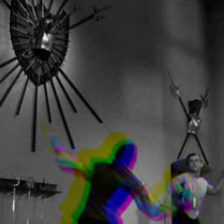

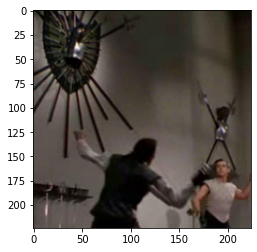

In [ ]:
state = train_dataset.state_dict()

for iter, data in enumerate(train_loader, 0):
    videos = data["videos"]
    labels = data["labels"]
    indexes = data["indexes"]

    plt.imshow(videos[0][0])

    flows = getOpticalFlow(videos)

    SG3I = getSG3I(videos)

    break

# Temporal Model

In [9]:
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
import random
import torchvision
import torchvision.models as models
import torch.optim as optim

class TemporalStream(torch.nn.Module):

    def __init__(self,
                 device='cuda',
                 num_classes=51,
                 dropout_probability=0.5):

        # Initialize the stream layers
        super(TemporalStream, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Backbone
        self.temporal = models.resnet50(pretrained=True)
        for param in self.temporal.parameters():
            param.requires_grad = True

        self.temporal.fc = nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Linear(1024, self.num_classes),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Softmax())

    def forward(self, X):
        X = self.temporal(X)
        return X

    def compute_loss(self, output, target):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        return loss

# Train & Test

In [10]:
def train(epoch):
    temporal.train()
    counter = 0
    if epoch == last_epoch:
        counter = last_iter + 1
    train_loss = 0
    log_interval = 50
    save_interval = 200

    epoch_loss = []
    log_int_loss = 0
    for iter, data in enumerate(train_loader, 0):

        # Unpack data
        videos = data["videos"]
        labels = torch.tensor(data["labels"])
        indexes = data["indexes"]

        # Network input handling
        videos = videos.type(torch.FloatTensor)
        SG3I = getSG3I(videos)
        SG3I = SG3I.permute(0,3,1,2)
        SG3I = SG3I.to(device)

        # Network output
        optimizer.zero_grad()
        output = temporal(SG3I)
        output = output.to(device)
        labels = labels.to(device)

        # calculate losses
        loss = temporal.compute_loss(output, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Logging Interval
        log_int_loss += loss.item()
        epoch_loss.append(loss.item())

        if counter == 0:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss)
            train_loss_list.append(train_loss / batch_size)
            train_counter.append((iter + 1) * batch_size + epoch * len(train_loader.dataset))
            log_int_loss = 0
        elif counter % log_interval == log_interval - 1:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss / log_interval)
            train_loss_list.append(train_loss / batch_size)
            train_counter.append((iter + 1) * batch_size + epoch * len(train_loader.dataset))
            log_int_loss = 0

        if counter % save_interval == save_interval - 1:
            print('saving model for iter: ', counter)
            save_path = os.path.join(EPOCH_SAVE_PREFIX, 'temporal_epoch' + str(epoch) + '_iter_' + str(counter))
            torch.save({
                'epoch': epoch,
                'train_total_loss_list': train_loss_list,
                'epoch_total_loss_list': epoch_loss_list,
                'test_loss_list': test_loss_list,
                'train_counter': train_counter,
                'accuracy_list': accuracy_list,
                'model_state_dict': temporal.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)

        if counter == 3768:
          break

        counter += 1

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_loss_list.append(avg_loss)
    print('Epoch: ', epoch, ', avg total loss: ', avg_loss)


def test():
    temporal.eval()
    test_loss = 0
    correct = 0

    # Data Loop
    with torch.no_grad():
        for iter, data in enumerate(test_loader, 0):

            # Unpack data
            videos = data["videos"]
            labels = torch.tensor(data["labels"])
            indexes = data["indexes"]

            # Network input handling
            videos = videos.type(torch.FloatTensor)
            labels = labels.to(device)
            SG3I = getSG3I(videos)
            SG3I = SG3I.permute(0,3,1,2)
            SG3I = SG3I.to(device)

            # Network output
            output = temporal(SG3I)
            output = output.to(device)

            # calculate losses
            loss = temporal.compute_loss(output, labels)

            test_loss += loss.item()

            # calculate number of correct predictions in batch
            correct += sum(torch.argmax(output,1) == labels).item()
            if iter % 100 == 0:
                print ("iter  ", iter)
                print("accuracy so far = ", correct / ((iter + 1) * len(labels)))
    
    # Log
    test_loss_list.append(test_loss / len(test_loader.dataset))
    accuracy = correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('Avg Validation Loss: ', test_loss / len(test_loader.dataset))
    print('Accuracy: ', accuracy)

# Train Loop

In [ ]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_SG3I/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.001
temporal = TemporalStream()
temporal.to(device)
optimizer = optim.SGD(temporal.parameters(), lr=learning_rate, momentum=0.9)

# Epochs
num_epochs = 50

# Logging setup: train
train_loss_list = []
epoch_loss_list = []
train_counter = []

# Logging setup: test
test_loss_list = []
accuracy_list = []
epoch_list = np.arange(num_epochs)

# epoch loop
for epoch in range(num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'temporal_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_lsit': accuracy_list,
        'model_state_dict': temporal.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  0 , Batch:  0 , loss avg over log interval:  3.932321548461914
Epoch:  0 , Batch:  49 , loss avg over log interval:  3.853197627067566
Epoch:  0 , Batch:  99 , loss avg over log interval:  3.9316504049301146
Epoch:  0 , Batch:  149 , loss avg over log interval:  3.9315021944046022
Epoch:  0 , Batch:  199 , loss avg over log interval:  3.9311947441101074
saving model for iter:  199
Epoch:  0 , Batch:  249 , loss avg over log interval:  3.930749287605286
Epoch:  0 , Batch:  299 , loss avg over log interval:  3.9303851747512817
Epoch:  0 , Batch:  349 , loss avg over log interval:  3.929409971237183
Epoch:  0 , Batch:  399 , loss avg over log interval:  3.927215838432312
saving model for iter:  399
Epoch:  0 , Batch:  449 , loss avg over log interval:  3.9212195110321044
Epoch:  0 , Batch:  499 , loss avg over log interval:  3.909051704406738
Epoch:  0 , Batch:  549 , loss avg over log interval:  3.9044515037536622
Epoch:  0 , Batch:  599 , loss avg over log interval:  3.902359228

# Resume Train Loop

In [ ]:
import timeit

EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_SG3I/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.001
temporal = TemporalStream()
temporal.to(device)
optimizer = optim.SGD(temporal.parameters(), lr=learning_rate, momentum=0.9)

# Load model
last_epoch = 7
last_iter = 2599
network_path = EPOCH_SAVE_PREFIX + 'temporal_epoch' + str(last_epoch) + '_iter_' + str(last_iter)
checkpoint = torch.load(network_path)
temporal.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Epochs
num_epochs = 11

# Logging setup: train
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_list']
epoch_list = np.arange(num_epochs)

# Mid epoch retrain: 0, end of epoch retrain: 1
switch_epoch = 0

# epoch loop
for epoch in range(last_epoch + switch_epoch, num_epochs): 

    # Train & Validate
    train(epoch)
    test()

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'temporal_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': temporal.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  7 , Batch:  49 , loss avg over log interval:  3.6189580583572387
Epoch:  7 , Batch:  99 , loss avg over log interval:  3.608939561843872
Epoch:  7 , Batch:  149 , loss avg over log interval:  3.613851385116577
Epoch:  7 , Batch:  199 , loss avg over log interval:  3.6109411096572877
saving model for iter:  2799
Epoch:  7 , Batch:  249 , loss avg over log interval:  3.6078413105010987
Epoch:  7 , Batch:  299 , loss avg over log interval:  3.6263201808929444
Epoch:  7 , Batch:  349 , loss avg over log interval:  3.6171922969818113
Epoch:  7 , Batch:  399 , loss avg over log interval:  3.6129521703720093
saving model for iter:  2999
Epoch:  7 , Batch:  449 , loss avg over log interval:  3.6123831987380983
Epoch:  7 , Batch:  499 , loss avg over log interval:  3.6153286266326905
Epoch:  7 , Batch:  549 , loss avg over log interval:  3.621390061378479
Epoch:  7 , Batch:  599 , loss avg over log interval:  3.6100333595275877
saving model for iter:  3199
Epoch:  7 , Batch:  649 , loss

KeyboardInterrupt: ignored

# Plotting

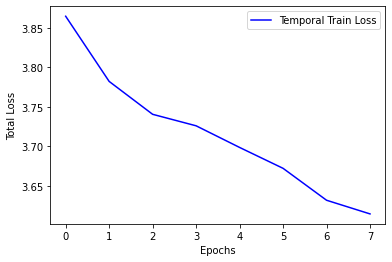

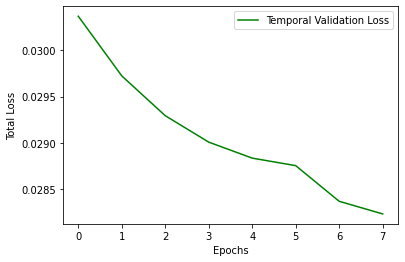

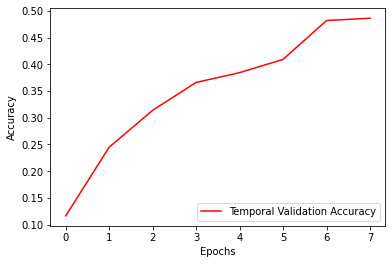

In [16]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/temporal_SG3I/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# Load params
last_epoch = 7

# load data
network_path = EPOCH_SAVE_PREFIX + 'temporal_epoch' + str(last_epoch)
checkpoint = torch.load(network_path)
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_list']
epoch_list = np.arange(last_epoch+1)

# plots
fig = plt.figure()
plt.plot(epoch_loss_list, color='blue')
plt.legend(['Temporal Train Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(test_loss_list, color='green')
plt.legend(['Temporal Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(accuracy_list, color='red')
plt.legend(['Temporal Validation Accuracy'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()